# **Classification task with Optical Neural Network (ONN)**

   ### In this nootbook, we use the optical neural network to perform three basic classification tasks
   
 ***
 Remember to execute the code sequentially. 
 ***

### Section 1: First steps
#### Imports
First of all, let us start importing the related libraries that we need to create and train our ML model. Please make sure that you have installed the iPronics package previously on your python environment, otherwise go to the first training notebook and run the installation cell.

In [45]:
import os
import joblib
import numpy as np  # linear algebra
import matplotlib.pyplot as plt
import iPronics.OpticalNeuralNetworks as ONN

from iPronics.OpticalNeuralNetworks import layers, losses, nonlinearities, optimizers
from iPronics.utilities.optimizers.scheduler import scheduler_operations_linear as schedule
from typing import Tuple

#### Helper functions
Once we have imported the necessary libraries, there are several functions that we are going to use in our tasks, by using these functions we can easily deal with our data preprocesing, ML training and plotting, all of below functions can be included/packged in a new toolbox module (API): utils.py for example
- functions for generate dataset: ring planar, diagonal planar and separable planar
- function for normalization
- function for split data in part of training and part of testing
- function for caculate accurancy of given model
- function for plotting cost function
- function for plotting the decision boundary for a model predicting planar datasets
- nonlinearity function: hyperbolic tangent function

In [46]:
def generate_ring_planar_dataset(N: int = 400, noise_ratio: float = 0.05, seed = None) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Generates a ring of points with one-hot labeling
    :param N: number of points to generate
    :param noise_ratio: multiplier for gaussian noise on radius
    :return: points, labels
    '''
    np.random.seed(seed)
    points = 2 * (np.random.rand(2 * N).reshape((N, 2))) - 1 
    labels = np.zeros((N, 2))
    for i, point in enumerate(points):
        if 0.4 <= np.linalg.norm(point) + noise_ratio * np.random.randn() <= 0.8:
            labels[i][0] = 1
        else:
            labels[i][1] = 1
    return points, labels

In [47]:
def generate_diagonal_planar_dataset(N: int = 400, noise_ratio: float = 0.05, seed = None) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Generates a diagonal of points with one-hot labeling
    :param N: number of points to generate
    :param noise_ratio: multiplier for gaussian noise on radius
    :return: points, labels
    '''
    np.random.seed(seed)
    points = 2 * (np.random.rand(2 * N).reshape((N, 2))) - 1
    labels = np.zeros((N, 2))
    for i, pt in enumerate(points):
        if -0.4 <= pt[0] + pt[1] + noise_ratio * np.random.randn() <= 0.4:
            labels[i][0] = 1
        else:
            labels[i][1] = 1
    return points, labels

In [48]:
def generate_separable_planar_dataset(N: int = 400, noise_ratio: float = 0.0, seed = None) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Generates a separable of points with one-hot labeling
    :param N: number of points to generate
    :param noise_ratio: multiplier for gaussian noise on radius
    :return: points, labels
    '''
    np.random.seed(seed)
    points = 2 * (np.random.rand(2 * N).reshape((N, 2))) - 1
    labels = np.zeros((N, 2))
    for i, pt in enumerate(points):
        if pt[0] + pt[1] + noise_ratio * np.random.randn() < 0:
            labels[i][0] = 1
        else:
            labels[i][1] = 1
    return points, labels

In [8]:
def normalize_inputs(data: np.ndarray, num_inputs: int, P0: int = 10) -> np.ndarray:
    '''
    Reshapes the inputs to fit into the specified mesh size and normalizes input data to 
    have the same total power input by injecting extra power to an "unused" input port.
    :param X: the input data
    :param num_inputs: the size of the network (number of waveguides)
    :param P0: the total power to inject with each data input
    :return: data_normalized
    '''
    _, input_size = data.shape
    injection_port = input_size
    data_normalized = np.array(np.pad(data, ((0, 0), (0, num_inputs - input_size)), mode="constant"))
    for i, x in enumerate(data_normalized):
        data_normalized[i][injection_port] = np.sqrt(P0 - np.sum(x**2))
    return data_normalized

In [49]:
def train_test_split(X_data: np.ndarray, 
                     Y_output: np.ndarray, 
                     test_size: float = 0.2, 
                     shuffle: bool = True) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    '''
    Split input data arrays or matrices into random train and test subsets.
    :param X_data: the input data
    :param Y_features: the input features data 
    :param test_size: the percentage of input data which used to testing. If ''test_size'' is None, it will be set to 0.2
    :param shuffule: whether or not to shuffle the data before splitting, default=True
    :return: the input data splitted
    '''
    total_length = len(Y_output)
    train_length = int((1-test_size) * total_length)
    test_length = int(test_size * total_length) 
    
    if shuffle is True:
        np.random.shuffle(X_data)
        np.random.shuffle(Y_output)       
    
        X_train = X_data[:train_length] 
        X_test = X_data[:test_length]  
        Y_train = Y_output[:train_length]
        Y_test = Y_output[:test_length]
    
    else:
        
        X_train = X_data[:train_length] 
        X_test = X_data[:test_length]  
        Y_train = Y_output[:train_length]
        Y_test = Y_output[:test_length]
        
    return X_train, X_test, Y_train, Y_test

In [7]:
def get_model_accuracies( dataset_array: np.ndarray, model: ONN.models.Sequential):
    '''
    Takes the given model and dataset to calculate the accuracy for trained model
    :param dataset_array: data array
    :param model: the machine model after trained
    :return:
    '''
    X_train = dataset_array[0]
    X_test = dataset_array[1]
    Y_train = dataset_array[2]
    Y_test = dataset_array[3]
    
    print("TESTING THE TRAINED NETWORK")
    
    # Training accuracy
    print("Training accuracy:")
    prediction = model.forward_pass(X_train.T)
    n_features = prediction.shape[1]
    Y_label = np.argmax(Y_train, axis=1)
    print("y label: ", Y_label[:5])
    print("y label shape: ", Y_label.shape)
    predict_label = np.argmax(prediction, axis=0)
    print("prediction labels: ", predict_label[:5])
    print("prediction label shape: ", predict_label.shape)

    train_accuracy = np.sum(Y_label == predict_label) / n_features * 100
    print("Training accuracy of the dataset", train_accuracy)
    
    # Testing accuracy
    print("Testing accuracy:")
    prediction = model.forward_pass(X_test.T)
    n_features = prediction.shape[1]
    Y_label = np.argmax(Y_test, axis=1)
    print("y label: ", Y_label[:5])
    print("y label shape: ", Y_label.shape)
    predict_label = np.argmax(prediction, axis=0)
    print("prediction labels: ", predict_label[:5])
    print("prediction label shape: ", predict_label.shape)
    
    test_accuracy = np.sum(Y_label == predict_label) / n_features * 100
    print("Test accuracy of the dataset", test_accuracy)
    

In [8]:
def plot_cost_function(epochs: int, losses: list):
    '''
    Plots the cost function for a model predicting datasets
    :param epochs: the number times that the learning algorithm worked through the entire training dataset
    :param losses: the model's training error 
    :return:
    '''
    
    fig1, ax1 = plt.subplots()
    plt.semilogy(np.arange(epochs), losses)
    plt.xlabel("epochs")
    plt.ylabel("Cost function")
    plt.grid("on")
    plt.show()

In [9]:
def plot_planar_boundary(X: np.ndarray, Y: np.ndarray, model: ONN.models.Sequential, grid_points: int = 20, P0: int = 10):
    '''
    Plots the decision boundary for a model predicting planar datasets
    :param X: shape (n_features, n_samples), first two features are x, y coordinates
    :param Y: true labeles, (n_features, n_samples)
    :param model: a trained neuroptica model
    :param grid_points: number of grid points to render
    :param P0: normalization power to shine into other ports to keep total power equal
    :return:
    '''
    
    labels = np.array([0 if yi[0] > yi[1] else 1 for yi in np.abs(Y)]).flatten() # True labels

    # Prepare a grid of inputs to predict
    x_min, y_min = np.min(X, axis=0)[0:2]
    x_max, y_max = np.max(X, axis=0)[0:2]
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_points), np.linspace(x_min, x_max, grid_points))
    N = model.layers[0].input_size
    inputs = np.array([xx.flatten(), yy.flatten()]).T
    inputs = normalize_inputs(inputs, N, P0=P0).T

    # Predict the function value for the whole grid
    Y_hat = model.forward_pass(inputs).T
    Y_hat = [(0 if yhat[0] > yhat[1] else 1) for yhat in Y_hat]
    Z = np.array(Y_hat).reshape(xx.shape)

    # Plot the contour and training examples
    plt.figure(figsize=(7.5, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:,0], X[:,1], c=labels, cmap=plt.cm.Spectral)

    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])
    plt.colorbar()
    plt.show()

### Section 2: Separable planar dataset classification
#### Input data
Let's start with our first task, which is to classify a separable planar. As the beginning, we generate the dataset from the previously defined function. We can see that the dataset is generated as type of $ndarray$, it contains an array of data "$X$" and another output data array "$Y$". With all of this information we are going to train and test our model, the model is composed by 2 layers and 5 neurons per layer, the specific model contents we will check later.

In [38]:
X, Y = generate_separable_planar_dataset()
N = 5 #5 neurons per layer

#### Data preprocesing
It is important to preprocess the data before we feed our model, because the quality of data and the useful information that can be derived from it directly affects the ability of our model to learn, therefore, firstly we call the normalization function to add 3 more inputs (reshape) in order to match the ONN size, after we split the dataset into 20% for testing and 80% for traning, since the data has been randomly generated, thus we don't have to shuffle them again.

In [11]:
X_normalized = normalize_inputs(X, N)
dataset_array = train_test_split(X_normalized, Y, test_size=0.2, shuffle = False)
X_train = dataset_array[0]
X_test = dataset_array[1]
Y_train = dataset_array[2]
Y_test = dataset_array[3]

#### Defining a model and optimizing it
Our model can be now defined after preprocesed data, as mentioned before, we are going to set the model by 5 inputs, only 2 hidden layers will be used, due to the dataset is simple in this case. We use the activation function $Tanh$ because of the input interval is between [-1 - 1], therefore no information loss in the negative part, moreover $Tanh$ has better performance than $Sigmoid$.
On the other hand, as we are dealing with classification problem, we will use the categorical cross entropy as our cost function, and optimizer Adam is used to this model which can fast convergence speed.

ℒ = 2.11e-02: 100%|██████████| 1000/1000 [09:31<00:00,  1.75it/s]


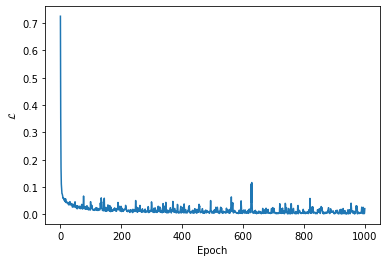

In [15]:
model = ONN.models.Sequential (
    [
    layers.ClementsLayer(N),
    layers.Activation(nonlinearities.Square(N)), 
    layers.ClementsLayer(N),
    layers.DropMask(N, keep_ports=[0,1]),
    ]
)

cost = ONN.losses.CategoricalCrossEntropy

optimizer = optimizers.Adam(model, cost, step_size=0.02, beta1=0.9, beta2=0.999, epsilon=1e-8)

epochs = 1000
batch_size = 8

losses = optimizer.fit(X_train.T, Y_train.T, epochs=epochs, batch_size=batch_size)

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("$\mathcal{L}$")
plt.show()

#### Testing the trained model
Now we have the model trained, so let's check how it's performance

TESTING THE TRAINED NETWORK
Training accuracy:
y label:  [0 0 1 1 0]
y label shape:  (320,)
prediction labels:  [0 0 1 1 0]
prediction label shape:  (320,)
Training accuracy of the dataset 99.375
Testing accuracy:
y label:  [0 0 1 1 0]
y label shape:  (80,)
prediction labels:  [0 0 1 1 0]
prediction label shape:  (80,)
Test accuracy of the dataset 100.0


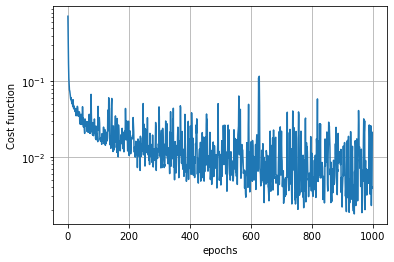

In [16]:
model.layers.append(layers.Activation(nonlinearities.SoftMax(2)))
get_model_accuracies(dataset_array, model)
plot_cost_function(epochs=epochs, losses=losses)

Hmmm, the accuracy doesn't look bad right? As the data is very simply to classify, we even can reduce epochs and remove one layer more. Ok, let's see how our model to classify separable planar dataset.

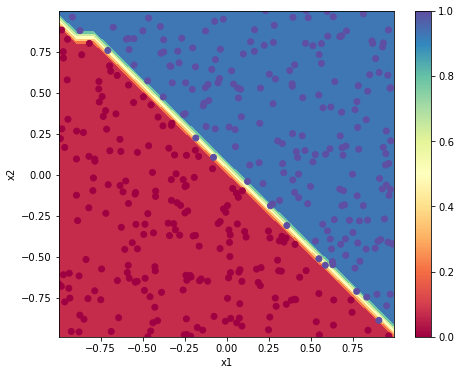

In [14]:
plot_planar_boundary(X, Y, model)

### Section 3: Diagonal planar dataset classfication
We upgrade the difficulty slightly, in this task we need to do a diagonal planar dataset classification. Same as the previous example, we are going to load dataset

#### Load & preprocess data

In [28]:
X, Y = generate_diagonal_planar_dataset()
print(X[:5])
N = 5
X_normalized = normalize_inputs(X, N)
dataset_array = train_test_split(X_normalized, Y, test_size=0.2, shuffle = False)
X_train = dataset_array[0]
X_test = dataset_array[1]
Y_train = dataset_array[2]
Y_test = dataset_array[3]

[[-0.3695361   0.00732872]
 [ 0.58279132  0.86354333]
 [-0.55614789 -0.5425932 ]
 [-0.74590932  0.16514776]
 [-0.14011287 -0.21326315]]


#### Optimizing model with new data
Since the new classification problem is quite similar like previous one, we are going to use the same model to deal with this task.

ℒ = 7.10e-02: 100%|██████████| 1000/1000 [02:24<00:00,  6.91it/s]


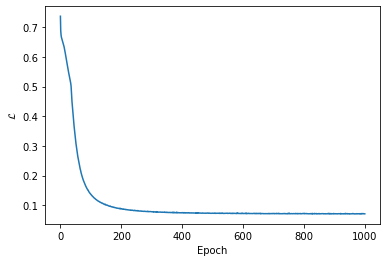

In [18]:
model = ONN.models.Sequential (
    [
    layers.ClementsLayer(N),
    layers.Activation(nonlinearities.Tanh(N)), 
    layers.ClementsLayer(N),
    layers.DropMask(N, keep_ports=[0,1]),
    ]
)

cost = ONN.losses.CategoricalCrossEntropy

optimizer = optimizers.Adam(model, cost, step_size=0.02, beta1=0.9, beta2=0.999, epsilon=1e-8)
losses = optimizer.fit(X_train.T, Y_train.T, epochs=1000, batch_size=32)

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("$\mathcal{L}$")
plt.show()

#### Model's accuracy & plotting result
Once trained our model with new dataset, our model's accuracy can be determined using the training and test datasets.

TESTING THE TRAINED NETWORK
Training accuracy:
y label:  [0 0 0 1 0]
y label shape:  (320,)
prediction labels:  [0 0 0 1 1]
prediction label shape:  (320,)
Training accuracy of the dataset 97.5
Testing accuracy:
y label:  [0 0 0 1 0]
y label shape:  (80,)
prediction labels:  [0 0 0 1 1]
prediction label shape:  (80,)
Test accuracy of the dataset 98.75


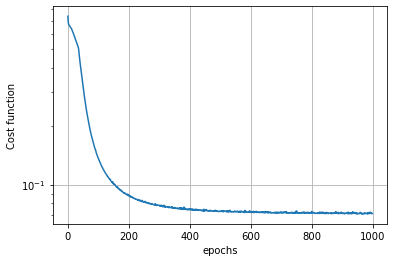

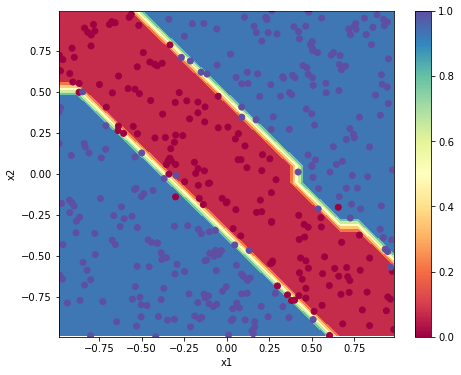

In [19]:
model.layers.append(layers.Activation(nonlinearities.SoftMax(2)))
get_model_accuracies(dataset_array, model)
plot_cost_function(epochs=1000, losses=losses)
plot_planar_boundary(X, Y, model)

### Section 4: Ring planar dataset classification
Now we come to the interesting section, in this task we are going to classify a ring planar dataset, which is more complex than above two examples. Regarding to this case, only 2 hidden layers are no longer enough to achive good learning accuracy, therefore we add 3 layers more in order to improve the performance.

Same like always, we should load our dataset as first, then normalize and split them for training and testing.

In [10]:
X, Y = generate_ring_planar_dataset()
N = 5
X_normalized = normalize_inputs(X, N)
dataset_array = train_test_split(X_normalized, Y, test_size=0.2, shuffle = False)
X_train = dataset_array[0]
X_test = dataset_array[1]
Y_train = dataset_array[2]
Y_test = dataset_array[3]

#### ML model

As mentioned, the ONN has been extended to 5 hidden layers, usually we say "$the$ $deeper$, $the$  $better$", the deeper number of layers means the more parameters can be adjusted, thus the result fitting is better, however, continuously deepening the neural network will bring about some negative problems, such as vanishing gradient problem, exploding gradient problem, overfitting, etc. Hence, in addition to add more layers in neural network, we can also try some other activation function, such as Leaky ReLU, SeLU, etc. Back to our case, this time we use 5 hidden layers with Tanh activation function.

ℒ = 1.61e-01: 100%|██████████| 1000/1000 [05:57<00:00,  2.80it/s]


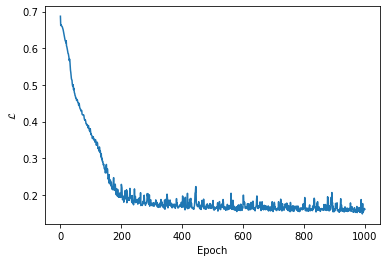

In [12]:
model = ONN.models.Sequential (
    [
    layers.ClementsLayer(N),
    layers.Activation(nonlinearities.Tanh(N)), 
    layers.ClementsLayer(N),
    layers.Activation(nonlinearities.Tanh(N)), 
    layers.ClementsLayer(N),
    layers.Activation(nonlinearities.Tanh(N)),
    layers.ClementsLayer(N),
    layers.Activation(nonlinearities.Tanh(N)),
    layers.ClementsLayer(N),
    layers.DropMask(N, keep_ports=[0,1]),
    ]
)

cost = ONN.losses.CategoricalCrossEntropy

optimizer = optimizers.Adam(model, cost, step_size=0.02, beta1=0.9, beta2=0.999, epsilon=1e-8)

epochs = 1000
batch_size = 32

losses = optimizer.fit(X_train.T, Y_train.T, epochs=epochs, batch_size=batch_size)

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("$\mathcal{L}$")
plt.show()

Once the new model is trained, we can check it's accuracy. For a good model, the accuracy should always keep above 90%

TESTING THE TRAINED NETWORK
Training accuracy:
y label:  [1 0 0 0 1]
y label shape:  (320,)
prediction labels:  [0 0 0 0 1]
prediction label shape:  (320,)
Training accuracy of the dataset 94.0625
Testing accuracy:
y label:  [1 0 0 0 1]
y label shape:  (80,)
prediction labels:  [0 0 0 0 1]
prediction label shape:  (80,)
Test accuracy of the dataset 93.75


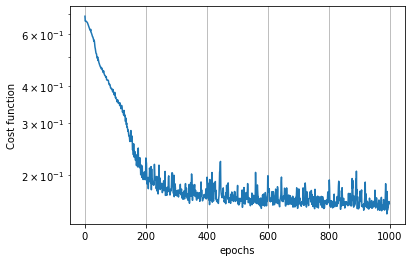

In [13]:
model.layers.append(layers.Activation(nonlinearities.SoftMax(2)))
get_model_accuracies(dataset_array, model)
plot_cost_function(epochs=epochs, losses=losses)

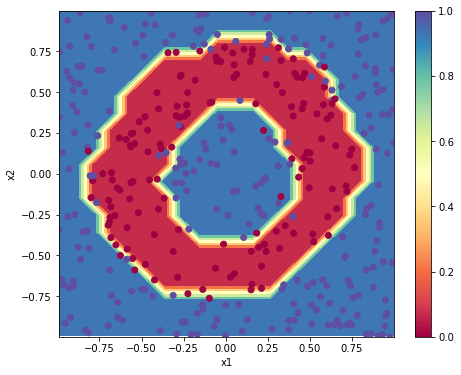

In [14]:
plot_planar_boundary(X, Y, model)

Regarding to this task, we have tried to reduce the layers while maintaining the same accuracy, the model can archive accuracy 93% by using 3 hidden layers but it becomes unstable. The activiation function Leaky ReLU, SeLU can be also tried as the furthur work.